**Target:**
- Setup Initial code, dataset loaders, transformation etc.
- Structure the code and get the training and validation loop operational.
- Train for less than 15 epochs, apply normalization on both train and test dataset as a transformation.
- Initial batch_size = 128 

**Result:**
- Total Parameters: 1,94,884
- Train Accuracy: 99.23% (Epoch - 13)
- Test Accuracy: 98.92% (Epoch - 13)

**Analysis:**
- Slight underfiting at start of the epoch and slight overfitting by the end of the epoch.
- Too many parameters.


**Receptive Field Calculation:**
```
Cin - Input Image Dimension
Rin - Initial Receptive field
Kernel - Size of kernel
Padding - Padding size 
Jin - Jump in
Jout - Jump output
RFnew - New Receptive field
Cout - Output Image dimension after convolution
Layers - Layer name
``` 

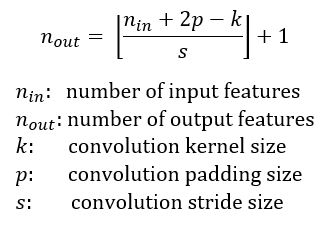

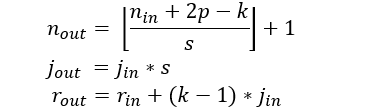

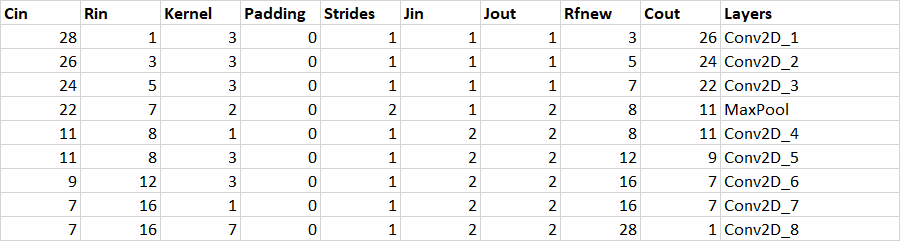

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

EPOCHS = 15
BATCH_SIZE = 128

In [ ]:
# setting the transforms and normalizing the images
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the train dataset with mean and std deviation
])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
])

# creating train and test dataset
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


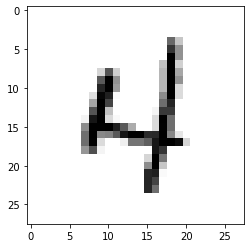

In [ ]:
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

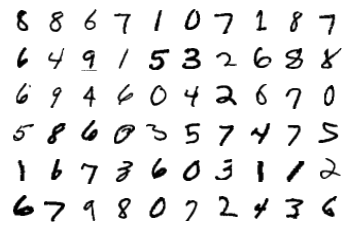

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        # Input: 28; Output: 26; Input Channel: 1; Output Channel: 32; kernel: 3; padding: 0;
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 1
        # Input: 26; Output: 24; Input Channel: 32; Output Channel: 64; kernel: 3; padding: 0;
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # Input: 24; Output: 22; Input Channel: 64; Output Channel: 128; kernel: 3; padding: 0;
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # TRANSITION BLOCK 1
        # Input: 22; Output: 11; Input Channel: 128; Output Channel: 32; kernel: 1; padding: 0;
        self.pool1 = nn.MaxPool2d(2, 2) # output = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )

        # CONVOLUTION BLOCK 2
        # Input: 11; Output: 9; Input Channel: 32; Output Channel: 64; kernel: 3; padding: 0;
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # Input: 9; Output: 7; Input Channel: 64; Output Channel: 128; kernel: 3; padding: 0;
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )

        # OUTPUT BLOCK
        # Input: 7; Output: 7; Input Channel: 128; Output Channel: 10; kernel: 3; padding: 0;
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )

        # Input: 7; Output: 1; Input Channel: 10; Output Channel: 10; kernel: 7; padding: 0;
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        )

    def forward(self, x):
        # receptive field details in README.md
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2380368858575821 Batch_id=468 Accuracy=63.10: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.1269, Accuracy: 9615/10000 (96.15%)

EPOCH: 1


Loss=0.06685858964920044 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]



Test set: Average loss: 0.0940, Accuracy: 9704/10000 (97.04%)

EPOCH: 2


Loss=0.08477882295846939 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Test set: Average loss: 0.0637, Accuracy: 9809/10000 (98.09%)

EPOCH: 3


Loss=0.06541550904512405 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]



Test set: Average loss: 0.0484, Accuracy: 9842/10000 (98.42%)

EPOCH: 4


Loss=0.04260660335421562 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]



Test set: Average loss: 0.0489, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.06476224213838577 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]



Test set: Average loss: 0.0464, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


Loss=0.016847318038344383 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]



Test set: Average loss: 0.0384, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.01544152107089758 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]



Test set: Average loss: 0.0357, Accuracy: 9875/10000 (98.75%)

EPOCH: 8


Loss=0.03567418083548546 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]



Test set: Average loss: 0.0458, Accuracy: 9863/10000 (98.63%)

EPOCH: 9


Loss=0.04467472434043884 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]



Test set: Average loss: 0.0377, Accuracy: 9886/10000 (98.86%)

EPOCH: 10


Loss=0.006679141893982887 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]



Test set: Average loss: 0.0420, Accuracy: 9866/10000 (98.66%)

EPOCH: 11


Loss=0.022094732150435448 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]



Test set: Average loss: 0.0357, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


Loss=0.0025936041492968798 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]



Test set: Average loss: 0.0373, Accuracy: 9884/10000 (98.84%)

EPOCH: 13


Loss=0.010341363959014416 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]



Test set: Average loss: 0.0371, Accuracy: 9892/10000 (98.92%)

EPOCH: 14


Loss=0.011963635683059692 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0391, Accuracy: 9889/10000 (98.89%)

